## Comparing Mine and Alfons postprocessing

In [1]:
import pandas as pd
import xarray as xr

In [2]:
# -- Paths to datafiles
main_path = '/home/ninalar/Documents/MC2' 
alf_path = '/2022-islas/Alfons_postprocessed/'
my_path = '/Results_2022-islas/Processed/'
cdp_a_file = main_path + alf_path + 'F15_data_CDP.csv'
cip_a_file = main_path + alf_path + 'F15_data_CIP.csv'

cdp_m_file = main_path + my_path + 'CDP_processed_test/CDP_updated_IS22-11.nc'
cip_m_file = main_path + my_path + 'CIP_processed/CIP_update_5s_IS22-11.nc'

In [3]:
# read in nav files
nav_file_nav = main_path + '/2022-islas/as220015/ISLAS_SAFIRE-ATR42_CORE_NAV_1HZ_20220403_as220015_L1_V1.nc'
nav_file_tdyn = main_path + '/2022-islas/as220015/ISLAS_SAFIRE-ATR42_CORE_TDYN_1HZ_20220403_as220015_L1_V1.nc'

nav_file_nav2 = main_path + '/2022-islas/as220015/ISLAS-2022_SAFIRE-ATR42_SAFIRE_CORE_NAV_1HZ_20220403_as220015_L2_V1.nc'
nav_file_tdyn2 = main_path + '/2022-islas/as220015/ISLAS-2022_SAFIRE-ATR42_SAFIRE_CORE_TDYN_1HZ_20220403_as220015_L2_V1.nc'

nav_xds = xr.open_dataset(nav_file_nav)
tdyn_xds = xr.open_dataset(nav_file_tdyn)
nav2_xds = xr.open_dataset(nav_file_nav2)
tdyn2_xds = xr.open_dataset(nav_file_tdyn2)

In [4]:
tdyn2_xds

<xarray.Dataset> Size: 3MB
Dimensions:       (time: 17181, level: 2)
Coordinates:
  * time          (time) datetime64[ns] 137kB 2022-04-03T11:55:34.240124 ... ...
    LATITUDE      (time) float32 69kB ...
    LONGITUDE     (time) float32 69kB ...
    ALTITUDE      (time) float32 69kB ...
Dimensions without coordinates: level
Data variables: (12/34)
    trajectory    |S100 100B ...
    time_bnds     (time, level) datetime64[ns] 275kB ...
    TOP           (time) float32 69kB ...
    PRES          (time) float32 69kB ...
    DYNP          (time) float32 69kB ...
    ALTP1         (time) float32 69kB ...
    ...            ...
    HABS3         (time) float32 69kB ...
    HABS4         (time) float32 69kB ...
    RH4           (time) float32 69kB ...
    RH3           (time) float32 69kB ...
    P_CABIN       (time) float32 69kB ...
    T_CABIN       (time) float32 69kB ...
Attributes: (12/39)
    creator_name:              Pascal Richard
    creator_email:             data@safire.fr
    flight_id:                 as220015
    processing_level:          L2
    featureType:               Trajectory
    flight_date:               2022-04-03
    ...                        ...
    geospatial_lat_min:        67.82052612304688
    geospatial_lat_max:        78.26508331298828
    license:                   https://creativecommons.org/licenses/by/4.0/de...
    NCO:                       netCDF Operators version 5.1.4 (Homepage = htt...
    history:                   Tue Dec 10 14:58:03 2024: ncatted -a acknowled...
    acknowledgement:           Airborne data was obtained using the aircraft ...

In [5]:
# read in alfons cdp and cip to pandas
cdp_df = pd.read_csv(cdp_a_file, header=20, skip_blank_lines=True)
cip_df = pd.read_csv(cip_a_file, header=20, skip_blank_lines=True)

# read in mine to xarray
cdp_xds = xr.open_dataset(cdp_m_file)
cip_xds = xr.open_dataset(cip_m_file)

In [41]:
print(cip_xds['MIDBINS'].attrs['units'])
print(cip_xds['CONCENTRATION'].attrs['units'])
print(cip_xds['IWC'].attrs['units'])

um
#/m4
gram/m3


In [42]:
# Testing recalculating IWC with Heymsfield 
# computed using alpha=0.0121, beta=1.9. Heymsfield (2010) relationship for warm clouds (T > -25°C))

massdim_param = {'Heymsfield2010': {'a':0.0121, 'b':1.9}}

#cip_xds

a = massdim_param['Heymsfield2010']['a']
b = massdim_param['Heymsfield2010']['b']

# mass calculation
#M = a*D^b

cip_xds['MASS_h'] = (1e-6)*a*cip_xds['MIDBINS']**b # in m from um
# update metadata for varianle
cip_xds['MASS_h'] = cip_xds['MASS_h'].assign_attrs({'long_name':'Mass from Heymsfield2010',
                                                    'source':'CIP',
                                                    'units':'g',
                                                    'description': f'CIP particle mass calculated from the Heymsfield (2010) mass-dimention relationship for warm clouds (T > -25°C). Computed the using alpha=0.0121, beta=1.9.'})


# Sjekk alle enheter!!!!
# IWC calculation
cip_xds['IWC_h'] = cip_xds['CONCENTRATION']*cip_xds['MASS_h']

cip_xds['IWC_h'] = cip_xds['IWC_h'].sum(dim='Vector64')
cip_xds

<xarray.Dataset> Size: 5MB
Dimensions:           (time: 2597, Vector64: 64, Vector40: 40)
Coordinates:
  * time              (time) datetime64[ns] 21kB 2022-04-03T12:38:44 ... 2022...
    lat               (time) float32 10kB ...
    lon               (time) float32 10kB ...
    alt               (time) float32 10kB ...
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/46)
    base_time         datetime64[ns] 8B ...
    utc_time          (time) float64 21kB 4.552e+04 4.553e+04 ... 5.85e+04
    TAS               (time) float32 10kB ...
    MIDBINS           (Vector64) float32 256B 25.0 50.0 ... 1.575e+03 1.6e+03
    ACTIVETIME        (time) float32 10kB ...
    SA                (Vector64) float32 256B ...
    ...                ...
    THEAD             (time) float32 10kB ...
    PITCH             (time) float32 10kB ...
    dfdx_thead        (time) float32 10kB ...
    SV_CIP            (Vector64, time) float32 665kB ...
    MASS_h            (Vector64) float32 256B 5.481e-06 2.046e-05 ... 0.01481
    IWC_h             (time) float32 10kB 0.0 2.159e+05 ... 6.106e+03 0.0
Attributes: (12/84)
    Source:                        SODA-2 OAP Processing Software
    DateCreated:                   Mon Feb  5 11:40:28 2024
    FlightDate:                    04/03/2022
    DateProcessed:                 Mon Feb  5 11:38:30 2024
    TimeInterval:                  12:38:44-16:15:04
    FN:                            /home/ninalar/Documents/MC2/2022-islas/as2...
    ...                            ...
    institution:                   The University of Bergen
    standard_name_vocabulary:      CF-1.8
    geospatial_lat_units:          degree_north
    geospatial_lon_units:          degree_east
    geospatial_vertical_units:     EPSG:4979
    product_version:               1

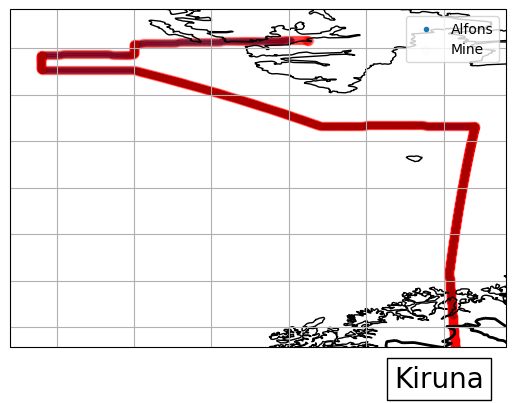

In [43]:
# Plot map to double check the flight is correct


# functions
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=2)
data_projection = ccrs.PlateCarree()

# get datavalues for plotting lines
lat_values = cdp_df.LATITUDE
lon_values = cdp_df.LONGITUDE
lat_mine = cdp_xds.LATITUDE.values
lon_mine = cdp_xds.LONGITUDE.values

# plot all lat-lon points
ax.scatter(lon_values, lat_values, marker='.', transform = data_projection, label=f'Alfons')
ax.scatter(lon_mine, lat_mine, marker='o', c='r',alpha=0.01, transform = data_projection, label=f'Mine')


#Plot Kiruna 
# coordinates of Kiruna
lat_kir = 67.8256
lon_kir = 20.3351
ax.plot(lon_kir, lat_kir, marker='^',markersize=16, color='red', transform=data_projection)
offset_lon = 0.95  # adjust the horizontal offset
offset_lat = -0.95  # adjust the vertical offset
ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", fontsize=20, transform=data_projection, ha='right', va='bottom',
        bbox=dict(facecolor='white', alpha=1, edgecolor='black', pad=5))

# set extent of the plot to the full area covered by the dataset +/- an increment of 1
ax.set_extent([lon_values.min()-1, lon_values.max()+1, lat_values.min()-1, lat_values.max()+1], crs=ccrs.PlateCarree())
ax.gridlines()

plt.legend()


In [44]:
cdp_xds['End Seconds'].values

array([45335.640625, 45336.640625, 45337.636719, ..., 59779.636719,
       59780.636719, 59781.636719], shape=(14447,))

In [45]:
min_time = cdp_xds.where(cdp_xds['End Seconds']>50000, drop=True)['time'].values.min()
max_time = cdp_xds.where(cdp_xds['End Seconds']<51000, drop=True)['time'].values.max()

max_time

np.datetime64('2022-04-03T14:09:59.000000000')

In [46]:
cdp_df['    0']

0       45534
1       45539
2       45544
3       45549
4       45554
        ...  
2590    58484
2591    58489
2592    58494
2593    58499
2594    58504
Name:     0, Length: 2595, dtype: int64

In [47]:
import numpy as np
#Select a subset of the data
# between 50000 and 51000
f_cdp_df = cdp_df[cdp_df['    0'].between(50000,51000)]
f_cdp_df = f_cdp_df[['    0','LWC']]
f_cdp_df = f_cdp_df.rename(columns={'    0':'0'})

f_cdp_xds = cdp_xds.where((cdp_xds['End Seconds']>=50000) & (cdp_xds['End Seconds']<=51000), drop=True)
# turn into pandas df with only end seconds and LWC
f_cdp_x_df = f_cdp_xds[['End Seconds','LWC','LWC calc']].to_dataframe()
f_cdp_x_df['0']=np.floor(f_cdp_x_df['End Seconds'])


cdp_merged = pd.merge(f_cdp_df, f_cdp_x_df[['0','LWC','LWC calc']], on='0', suffixes=('_a','_n') )

cdp_merged

,0,LWC_a,LWC_n,LWC calc
0,50004,3.029964e-06,2.608262e-06,0.000004
1,50009,1.339949e-06,1.138681e-06,0.000002
2,50014,1.948948e-05,1.646952e-05,0.000024
3,50019,1.439727e-05,1.225786e-05,0.000017
4,50024,4.432298e-03,3.799000e-03,0.004695
...,...,...,...,...
195,50979,9.260083e-07,8.345464e-07,0.000001
196,50984,0.000000e+00,0.000000e+00,0.000000
197,50989,2.177793e-06,1.973228e-06,0.000003
198,50994,9.224575e-07,8.345464e-07,0.000001


Text(0.5, 0.98, 'LWC from CDP')

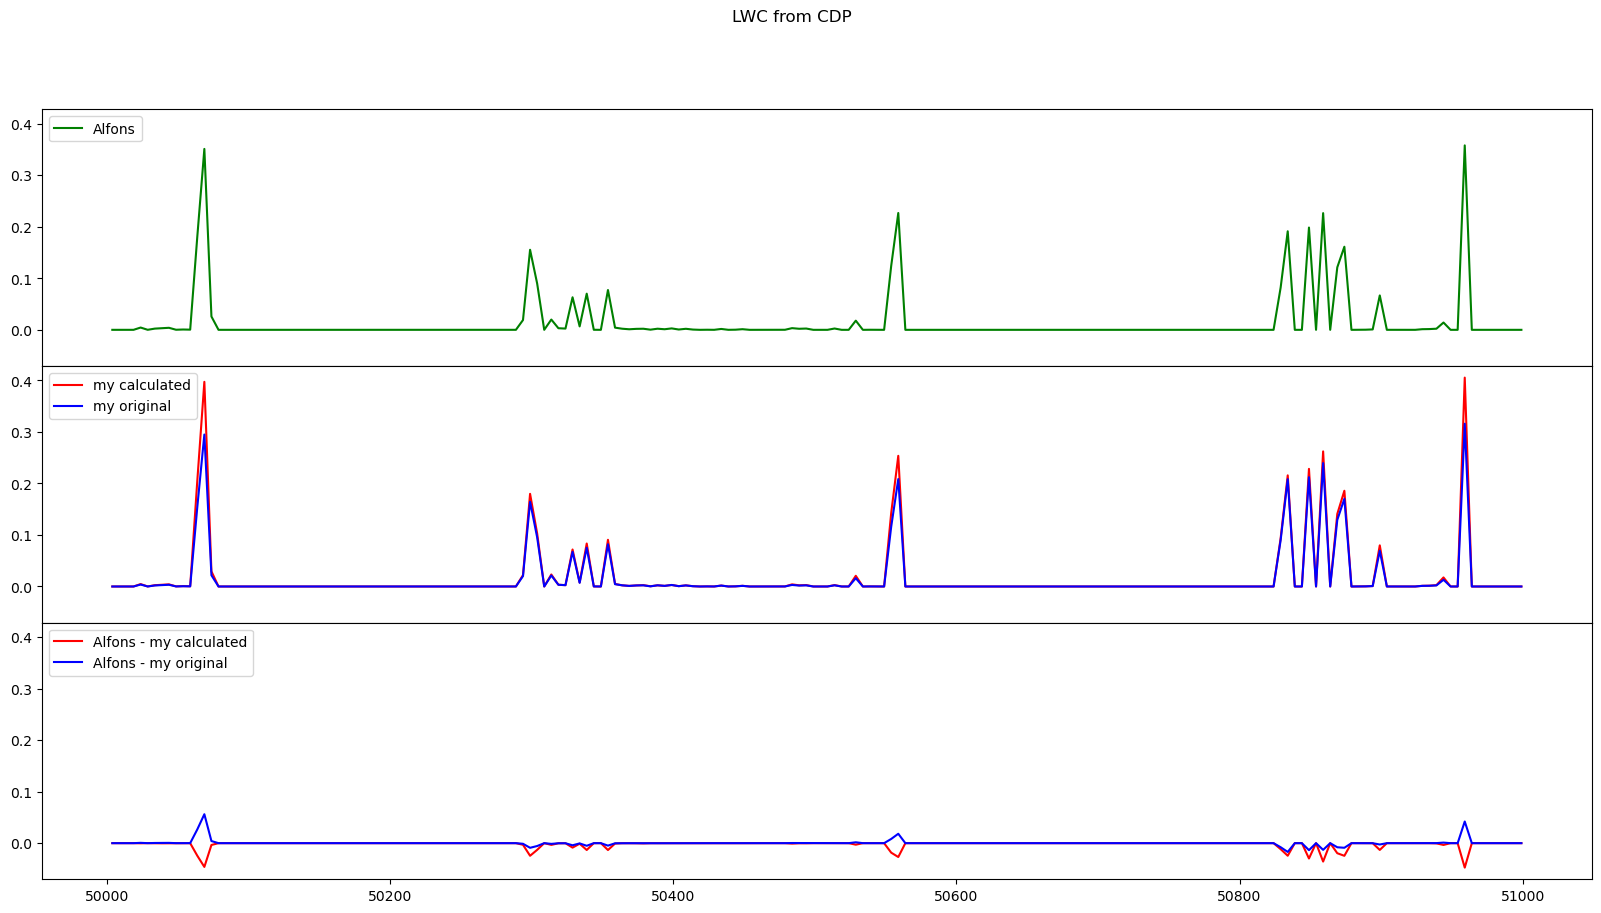

In [48]:
# Plot LWC

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(3,1, sharex=True, sharey=True)

fig.subplots_adjust(hspace=0)

ax[0].plot(cdp_merged['0'], cdp_merged['LWC_a'],c='g', label='Alfons')
ax[1].plot(cdp_merged['0'], cdp_merged['LWC calc'], c='r', label='my calculated')
ax[1].plot(cdp_merged['0'], cdp_merged['LWC_n'], c='b', label='my original')
ax[2].plot(cdp_merged['0'], cdp_merged['LWC_a']-cdp_merged['LWC calc'], c='r', label='Alfons - my calculated')
ax[2].plot(cdp_merged['0'], cdp_merged['LWC_a']-cdp_merged['LWC_n'], c='b', label='Alfons - my original')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')

fig.suptitle('LWC from CDP')
 

Text(0.5, 0.98, 'LWC from CDP')

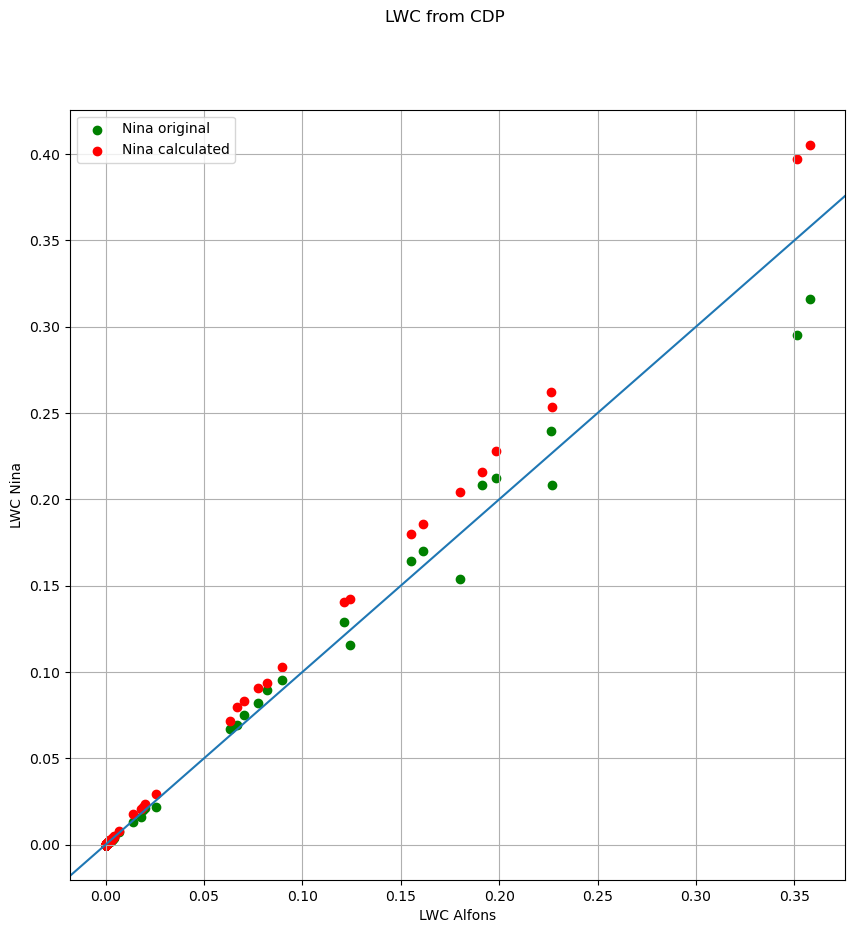

In [49]:
# Plot LWC vs LWC

fig = plt.figure(figsize=(10,10))
ax = fig.subplots(1,1)


ax.scatter(cdp_merged['LWC_a'], cdp_merged['LWC_n'],c='g', label='Nina original')
ax.scatter(cdp_merged['LWC_a'], cdp_merged['LWC calc'], c='r', label='Nina calculated')
ax.set_xlabel('LWC Alfons')
ax.set_ylabel('LWC Nina')
ax.axline((0,0),slope=1)
ax.legend(loc='upper left')

plt.grid(True)

fig.suptitle('LWC from CDP')
 



In [50]:
#Select a subset of the data
# between 50000 and 51000
f_cip_df = cip_df[cip_df['    0'].between(50000,51000)]
f_cip_df = f_cip_df[['    0','IWC']]
f_cip_df = f_cip_df.rename(columns={'    0':'utc_time'})

f_cip_xds = cip_xds.where((cip_xds['utc_time']>=50000) & (cip_xds['utc_time']<=51000), drop=True)
# turn into pandas df with only utc_time and IWC
f_cip_x_df = f_cip_xds[['utc_time','IWC','IWC100','IWC_h']].to_dataframe()


cip_merged = pd.merge(f_cip_df, f_cip_x_df[['utc_time','IWC','IWC100','IWC_h']], on='utc_time', suffixes=('_a','_n') )

cdp_merged

,0,LWC_a,LWC_n,LWC calc
0,50004,3.029964e-06,2.608262e-06,0.000004
1,50009,1.339949e-06,1.138681e-06,0.000002
2,50014,1.948948e-05,1.646952e-05,0.000024
3,50019,1.439727e-05,1.225786e-05,0.000017
4,50024,4.432298e-03,3.799000e-03,0.004695
...,...,...,...,...
195,50979,9.260083e-07,8.345464e-07,0.000001
196,50984,0.000000e+00,0.000000e+00,0.000000
197,50989,2.177793e-06,1.973228e-06,0.000003
198,50994,9.224575e-07,8.345464e-07,0.000001


### IWC from CIP

The postprocessed data from Alfons uses: 

computed using alpha=0.0121, beta=1.9. Heymsfield (2010) relationship for warm clouds (T > -25°C))

Soda 2 uses:

Brown/Francis 1995 alpha=0.00294, beta=1.9 (cirrus clouds)



Text(0.5, 0.98, 'IWC from CIP')

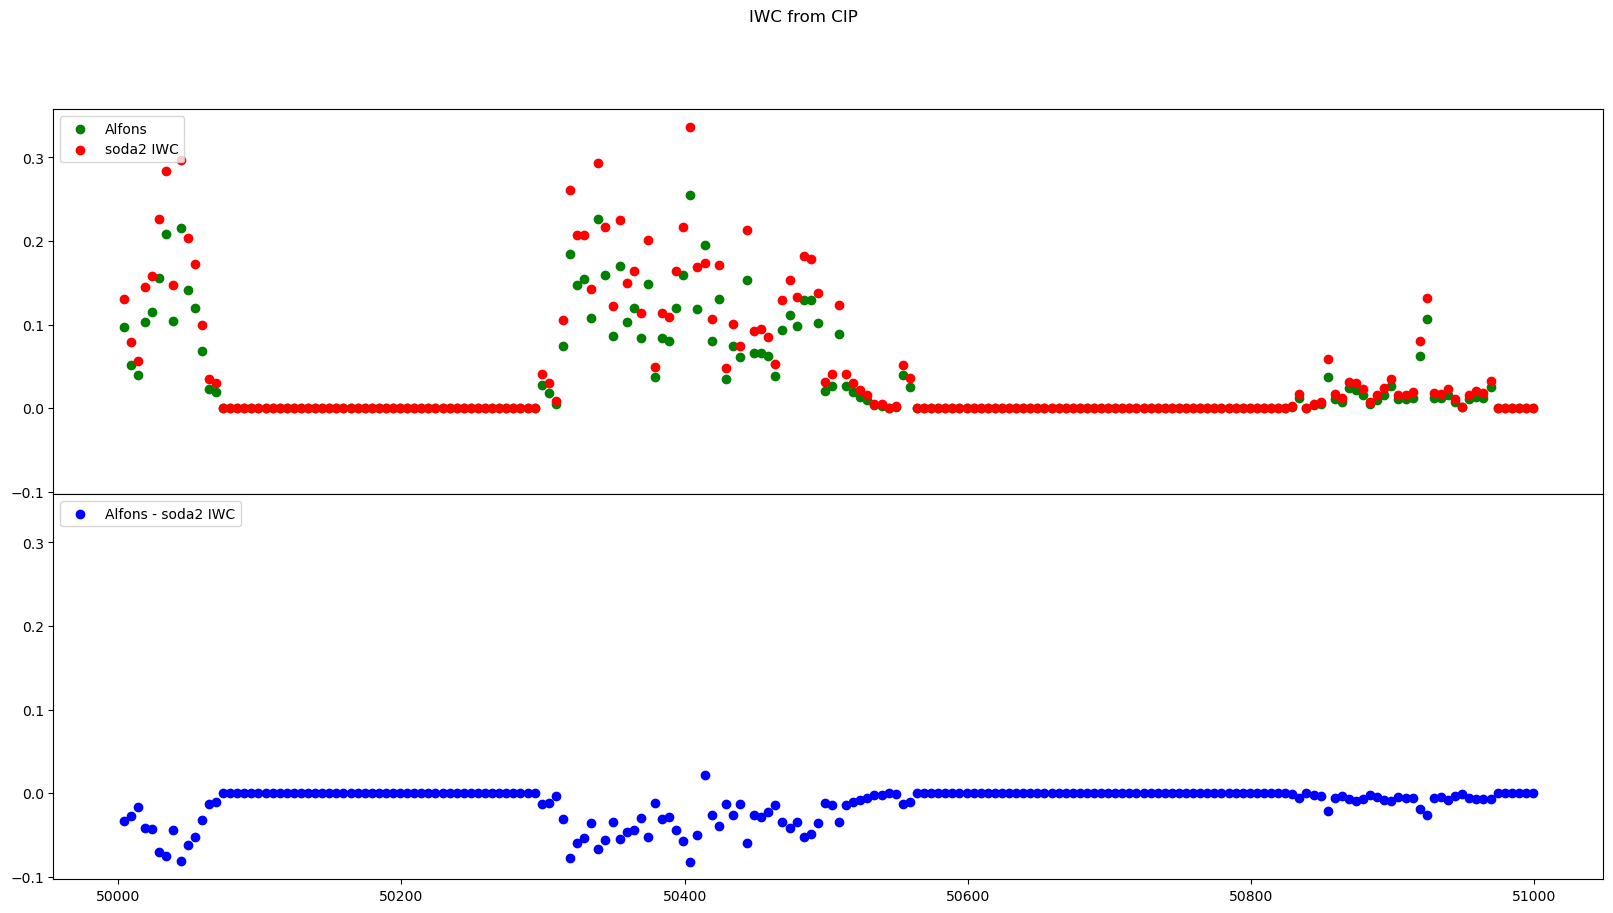

In [51]:
# Plot IWC

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2,1, sharex=True, sharey=True)

fig.subplots_adjust(hspace=0)

ax[0].scatter(cip_merged['utc_time'], cip_merged['IWC_a'],c='g', label='Alfons')
ax[0].scatter(cip_merged['utc_time'], cip_merged['IWC_n'], c='r', label='soda2 IWC')
ax[1].scatter(cip_merged['utc_time'], cip_merged['IWC_a']-cip_merged['IWC_n'], c='b', label='Alfons - soda2 IWC')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')


fig.suptitle('IWC from CIP')

In [52]:
cip_merged

,utc_time,IWC_a,IWC_n,IWC100,IWC_h
0,50004,0.096696,0.130263,0.130145,8.545812e+05
1,50009,0.052115,0.078995,0.078716,5.186841e+05
2,50014,0.039160,0.056157,0.055947,3.697176e+05
3,50019,0.102897,0.144565,0.144513,9.483247e+05
4,50024,0.115673,0.157855,0.157640,1.036133e+06
...,...,...,...,...,...
195,50979,0.000151,0.000332,0.000263,2.349368e+03
196,50984,0.000000,0.000000,0.000000,0.000000e+00
197,50989,0.000000,0.000000,0.000000,0.000000e+00
198,50994,0.000000,0.000000,0.000000,0.000000e+00


Text(0.5, 0.98, 'IWCs')

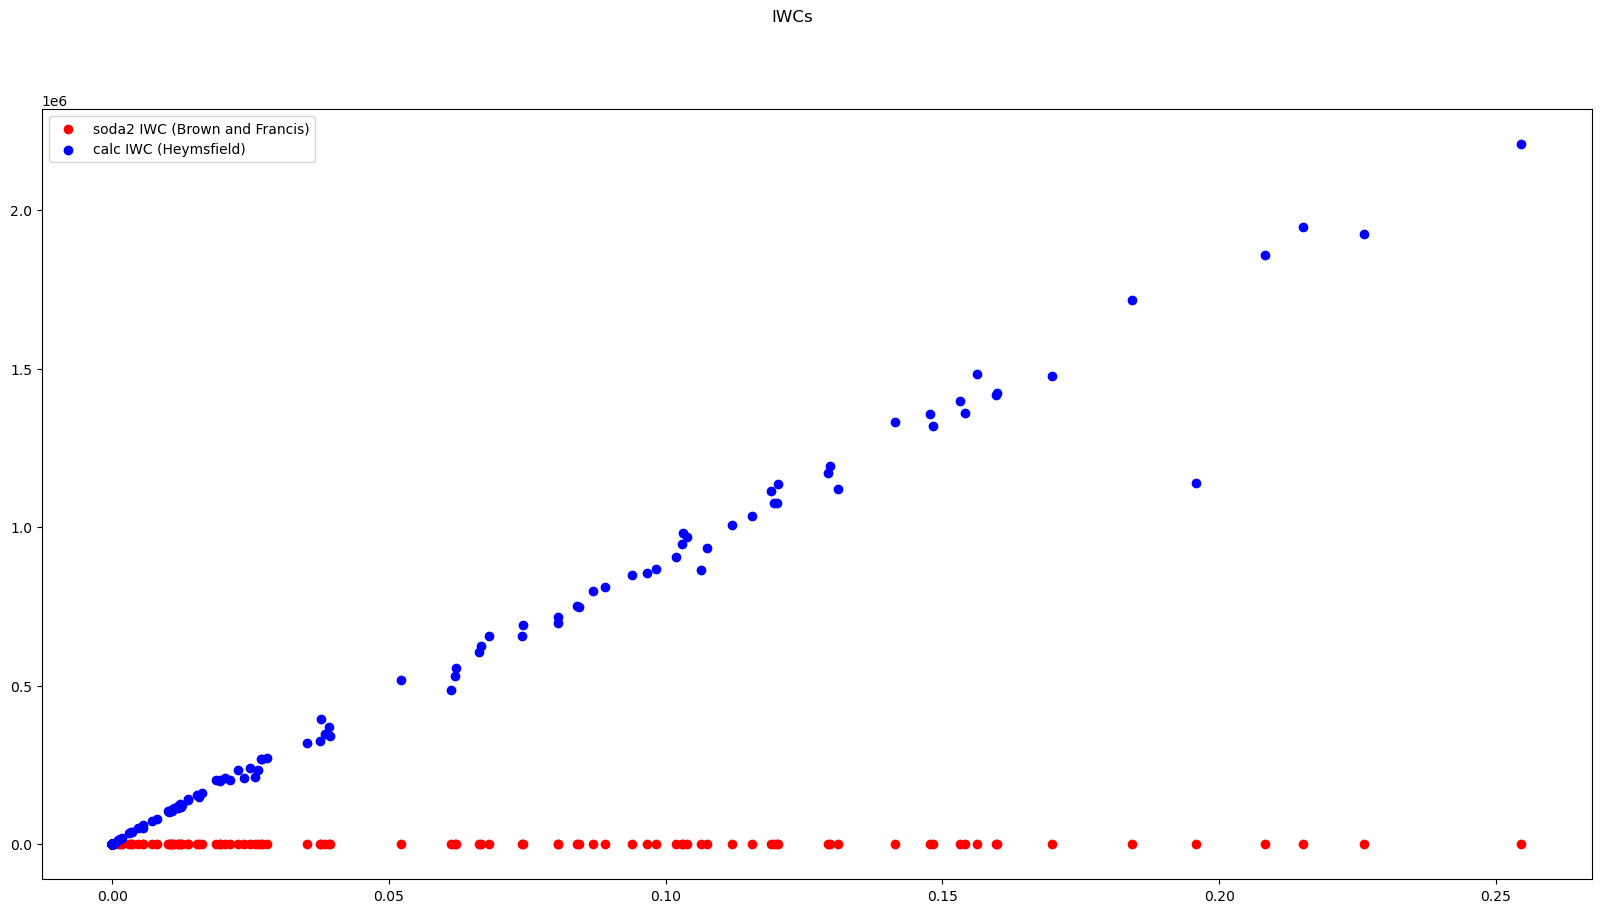

In [53]:
# Plot IWC

fig = plt.figure(figsize=(20,10))
ax = fig.subplots()

fig.subplots_adjust(hspace=0)

#ax.scatter(cip_merged['IWC_a'], cip_merged['IWC_a'],c='g', label='Alfons')
ax.scatter(cip_merged['IWC_a'], cip_merged['IWC_n'], c='r', label='soda2 IWC (Brown and Francis)')
ax.scatter(cip_merged['IWC_a'], cip_merged['IWC_h'], c='b', label='calc IWC (Heymsfield)')
ax.legend(loc='upper left')


fig.suptitle('IWCs')

In [18]:
tdyn_xds['TAS2'].attrs['comment']

'TAS from Avionic Static/Pitot system (ADC)'

/tmp/ipykernel_7430/74543792.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


Text(0.5, 0.98, 'TAS L1 vs TAS L2')

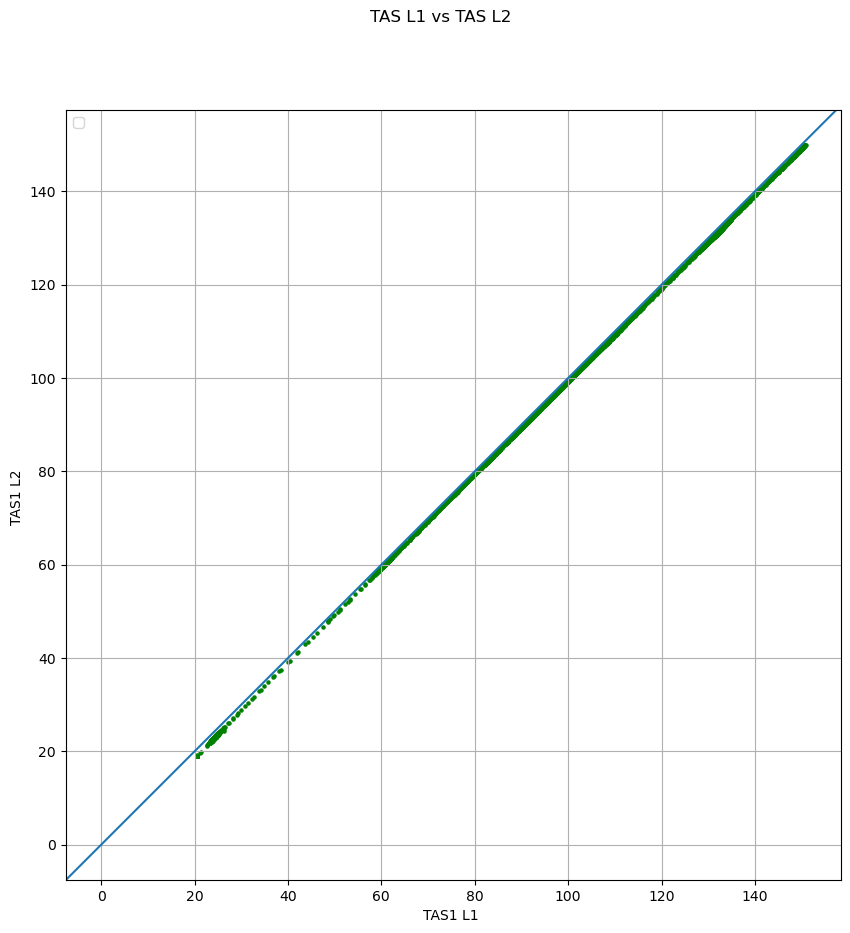

In [19]:
# Plot TAS1 vs TAS2

#tdyn_xds = tdyn_xds.where((tdyn_xds['time'].values>min_time.values) & (tdyn_xds['time'].values<max_time.values))

fig = plt.figure(figsize=(10,10))
ax = fig.subplots(1,1)


#ax.scatter(tdyn_xds['TAS1'].values, tdyn_xds['TAS2']/1.94384001,c='g')
ax.scatter(tdyn_xds['TAS1'].values, tdyn2_xds['TAS1'],c='g', s=5)
#ax.set_xlabel(f'TAS1 /n {tdyn_xds['TAS1'].attrs['comment']}')
#ax.set_ylabel(f'TAS2 /n {tdyn_xds['TAS2'].attrs['comment']}')
ax.set_xlabel(f'TAS1 L1 ')
ax.set_ylabel(f'TAS1 L2 ')
ax.axline((0,0),slope=1)
ax.legend(loc='upper left')

plt.grid(True)

fig.suptitle('TAS L1 vs TAS L2')

Text(0.5, 0.98, 'IWC from CIP')

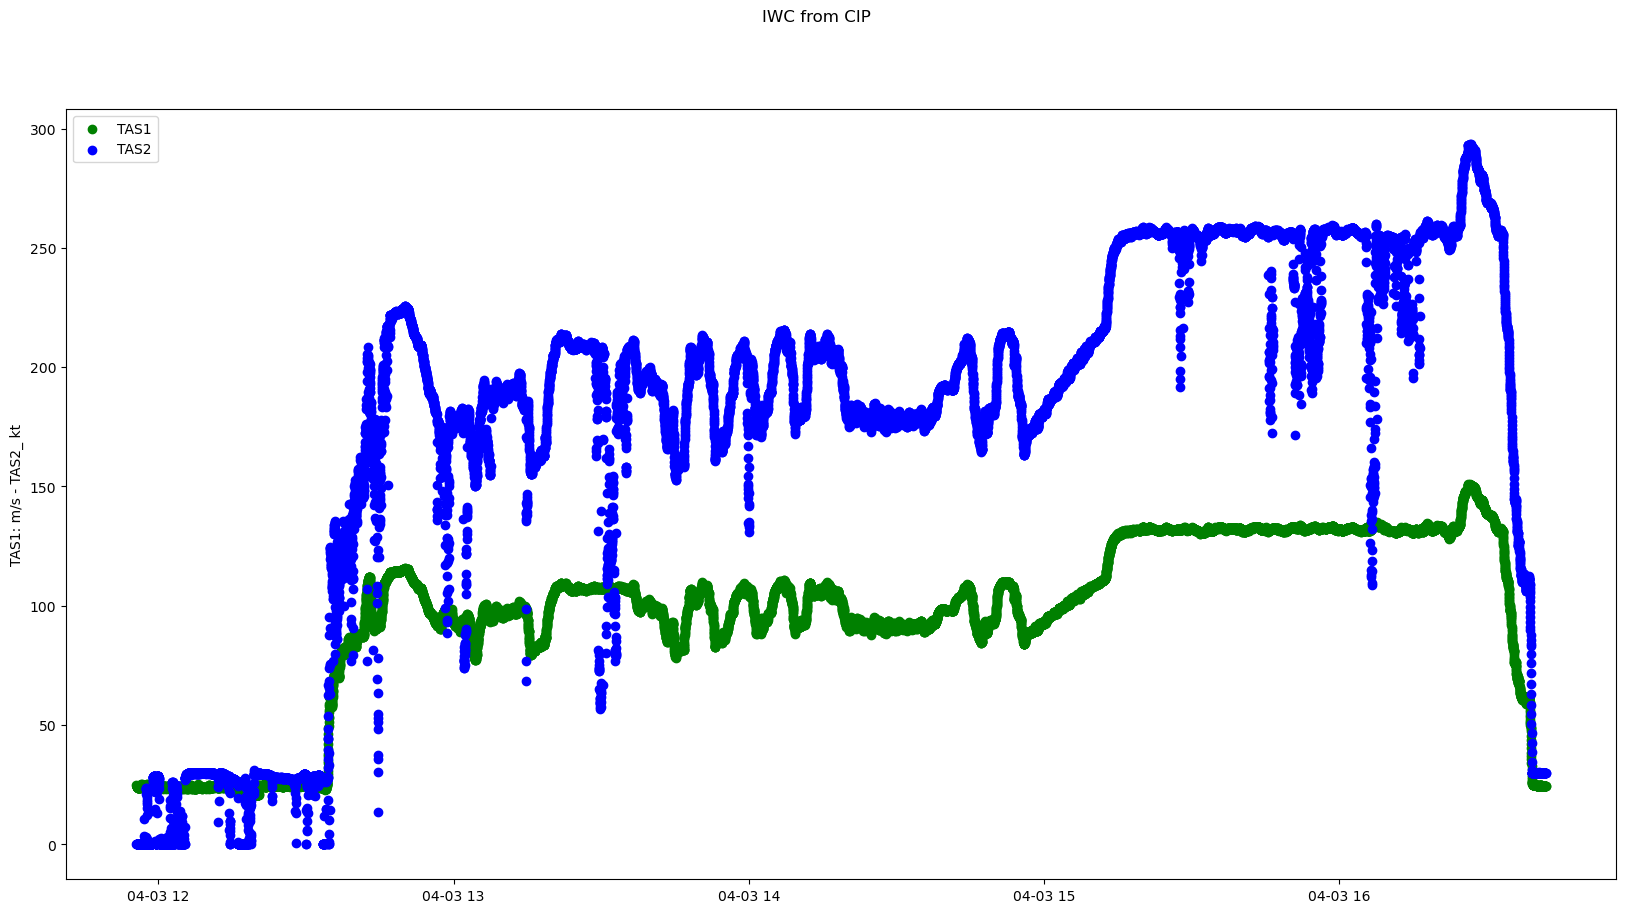

In [40]:
# Plot TAS ans TAS

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(1,1)

fig.subplots_adjust(hspace=0)

ax.scatter(tdyn_xds['time'], tdyn_xds['TAS1'],c='g', label='TAS1')
ax.scatter(tdyn_xds['time'], tdyn_xds['TAS2'], c='b', label='TAS2')
ax.set_ylabel(f'TAS1: {tdyn_xds['TAS1'].attrs['units']} - TAS2_ {tdyn_xds['TAS2'].attrs['units']}')
ax.legend(loc='upper left')



fig.suptitle('IWC from CIP')

In [43]:
cip_xds

<xarray.Dataset> Size: 5MB
Dimensions:           (time: 2597, Vector64: 64, Vector40: 40)
Coordinates:
  * time              (time) datetime64[ns] 21kB 2022-04-03T12:38:44 ... 2022...
    lat               (time) float32 10kB ...
    lon               (time) float32 10kB ...
    alt               (time) float32 10kB ...
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/46)
    base_time         datetime64[ns] 8B ...
    utc_time          (time) float64 21kB 4.552e+04 4.553e+04 ... 5.85e+04
    TAS               (time) float32 10kB ...
    MIDBINS           (Vector64) float32 256B 25.0 50.0 ... 1.575e+03 1.6e+03
    ACTIVETIME        (time) float32 10kB ...
    SA                (Vector64) float32 256B ...
    ...                ...
    THEAD             (time) float32 10kB ...
    PITCH             (time) float32 10kB ...
    dfdx_thead        (time) float32 10kB ...
    SV_CIP            (Vector64, time) float32 665kB ...
    MASS_h            (Vector64) float32 256B 5.481 20.46 ... 1.481e+04
    LWC_h             (Vector64, time) float32 665kB 0.0 12.15 6.074 ... 0.0 0.0
Attributes: (12/84)
    Source:                        SODA-2 OAP Processing Software
    DateCreated:                   Mon Feb  5 11:40:28 2024
    FlightDate:                    04/03/2022
    DateProcessed:                 Mon Feb  5 11:38:30 2024
    TimeInterval:                  12:38:44-16:15:04
    FN:                            /home/ninalar/Documents/MC2/2022-islas/as2...
    ...                            ...
    institution:                   The University of Bergen
    standard_name_vocabulary:      CF-1.8
    geospatial_lat_units:          degree_north
    geospatial_lon_units:          degree_east
    geospatial_vertical_units:     EPSG:4979
    product_version:               1